In [1]:
# Optimize Sigma Variation with ShareParameters

In [2]:
from desc import set_device
set_device("gpu")

In [3]:
import numpy as np
import os
# os.environ["JAX_LOG_COMPILES"] = "True"
from scipy.io import netcdf_file
import copy
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.constants import mu_0
import sys
import functools
import pickle

import jax
import jax.numpy as jnp
from jax import jit, jacfwd

from netCDF4 import Dataset
import h5py

from desc.backend import put, fori_loop, jnp, sign

from desc.basis import FourierZernikeBasis, DoubleFourierSeries, FourierSeries
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.grid import ConcentricGrid, LinearGrid, Grid, QuadratureGrid
from desc.io import InputReader, load
from desc.objectives import *
from desc.objectives.objective_funs import _Objective
from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_surfaces, plot_comparison

from desc.plotting import *

from desc.transform import Transform
from desc.vmec import VMECIO
from desc.derivatives import Derivative
from desc.geometry import FourierRZToroidalSurface
from desc.profiles import SplineProfile, PowerSeriesProfile

from desc.magnetic_fields import ( SplineMagneticField, 
                                  #biot_savart_general, 
                                  FourierCurrentPotentialField, ToroidalMagneticField,
                                  field_line_integrate)

import desc.examples

from desc.backend import fori_loop, jit, jnp, odeint, sign
from desc.compute import rpz2xyz, rpz2xyz_vec, xyz2rpz, xyz2rpz_vec
from desc.coils import *

from desc.utils import Timer, copy_coeffs, errorif, setdefault, svd_inv_null, warnif
from desc.utils import flatten_list
#from ..utils import cross, dot, safediv, safenorm
#from desc.compute.utils import cross
#from desc.compute.utils import dot

from desc.optimize import lsqtr, lsq_auglag

from scipy.optimize import NonlinearConstraint 

from desc.magnetic_fields import ( SplineMagneticField, 
                                  #biot_savart_general, 
                                  FourierCurrentPotentialField, 
                                  ToroidalMagneticField,
                                  field_line_integrate)

import time

import numpy as np
from numpy.linalg import eig

from scipy.linalg import null_space
from numpy import ndarray


from desc.derivatives import Derivative

DESC version 0.12.3+553.gcb761a802.dirty,using JAX backend, jax version=0.4.35, jaxlib version=0.4.34, dtype=float64

Using device: NVIDIA A100-SXM4-80GB (id=0), with 80.00 GB available memory

In [4]:
#from desc.continuation import solve_continuation_automatic

from desc.objectives import (
    #AspectRatio,
    #FixBoundaryR,
    #FixBoundaryZ,
    #FixCurrent,
    #FixPressure,
    #FixPsi,
    #ForceBalance,
    ObjectiveFunction,
    #QuasisymmetryTwoTerm,
    #RotationalTransform,
    FixParameters, 
    ShareParameters,
    QuadraticFlux, 
    SurfaceCurrentRegularization, 
    #bRegularization,
    PlasmaVesselDistance,
    MeanCurvature,
    PrincipalCurvature,
)
from desc.optimize import Optimizer

In [5]:
# Plasma surfaces
eqname_QA = "/home/fcastro/LMStell/regcoil/rogerio/input.QA_final_output.h5" #vacuum equilibrium
eq_QA = desc.io.load(eqname_QA)[4]

eqname_QH = "/home/fcastro/LMStell/regcoil/rogerio/input.QH_final_output.h5" #vacuum equilibrium
eq_QH = desc.io.load(eqname_QH)[4]

In [6]:
G_QA = eq_QA.compute("G")["G"][-1] / mu_0 * 2*np.pi
G_QH = eq_QH.compute("G")["G"][-1] / mu_0 * 2*np.pi

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

In [7]:
eq = eq_QA

R0 = 1.0
a = 0.3

surf = FourierRZToroidalSurface(R_lmn=[R0,a], 
                                Z_lmn=[-a],
                                modes_R=np.array([[0,0],[1,0]]),
                                modes_Z=np.array([[-1,0]]),
                                NFP=eq.NFP
                               )
surf.change_resolution(N=eq.N)

eq.axis.R_n = eq_QA.axis.R_n + 0.5*(eq_QH.axis.R_n - eq_QA.axis.R_n)
eq.axis.Z_n = eq_QA.axis.Z_n + 0.5*(eq_QH.axis.Z_n - eq_QA.axis.Z_n)

######
for coef, mode in zip(eq.axis.R_n, eq.axis.R_basis.modes):
    n = mode[-1]
    surf.R_lmn=surf.R_lmn.at[surf.R_basis.get_idx(M=0,N=n)].set( coef)
for coef, mode in zip(eq.axis.Z_n, eq.axis.Z_basis.modes):
    n = mode[-1]
    surf.Z_lmn=surf.Z_lmn.at[surf.Z_basis.get_idx(M=0,N=n)].set( coef)

In [8]:
surf1 = surf

surf1.change_resolution(M=12,N=12)

# Generate a Surface Current field for RQA
surf1 = FourierCurrentPotentialField.from_surface(surf1,M_Phi=12,N_Phi=12,sym_Phi=False, I=0, G=G_QA)

# Generate a Surface Current field for RQH
surf2 = surf1.copy()
surf2.G = G_QH

In [9]:
eq_QA.NFP

3

In [10]:
eq_QH.NFP

3

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

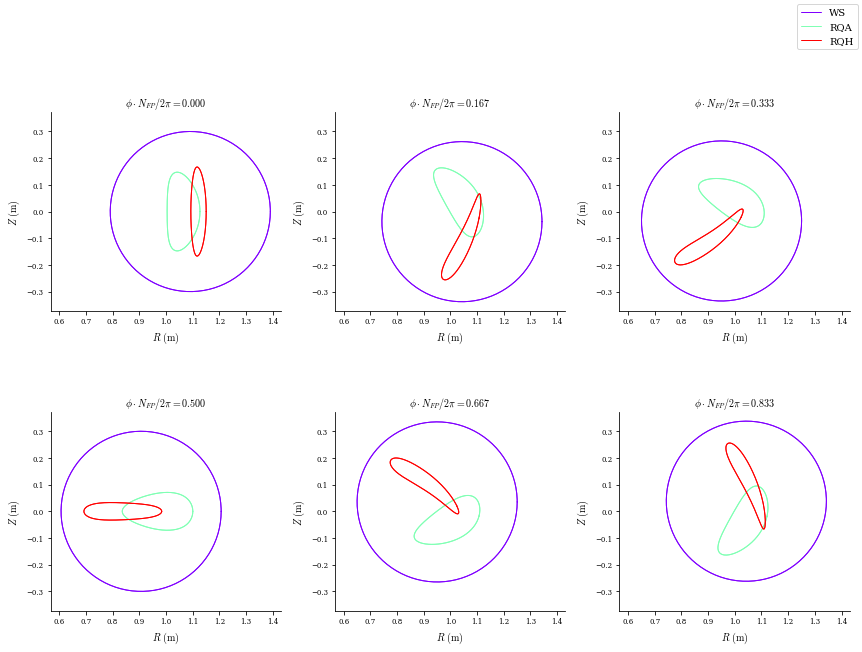

In [11]:
plot_comparison([surf1,eq_QA,eq_QH],
                labels=["WS","RQA","RQH"],
                theta=0,rho=np.array(1.0)
               )

In [12]:
## setup opt problem
# use QuadraticFlux as eq's are fixed and want fields to change
# use ShareParameters to keep surface geoms constant equal to eachother as they vary with surface current to reduce Bn
# first, keep surfs fixed too and just get regcoil-like solutions for each

In [13]:
# Grids
Megrid = 20
Negrid = 20

Msgrid = 20
Nsgrid = 20

egrid = LinearGrid(M=Megrid,N=Negrid,
                   #NFP = 1,
                   NFP=eq.NFP,
                   sym=False)

sgrid = LinearGrid(M=Msgrid,N=Nsgrid,
                   #NFP = 1,
                   NFP=eq.NFP,
                   sym=False) 

In [14]:
flux_QA = QuadraticFlux(eq_QA,surf1,field_grid=sgrid,
                        eval_grid=egrid,vacuum=True,
                        name="Bn error  eq_QA")

flux_QH = QuadraticFlux(eq_QH,surf2,field_grid=sgrid,
                        eval_grid=egrid,vacuum=True,
                        name="Bn error  eq_QH")

In [15]:
obj = ObjectiveFunction((flux_QA,
                         flux_QH,
                        )
                       )
constraints = (
    FixParameters(surf1,{"I":True,"G":True,"R_lmn":True, "Z_lmn":True}),
    FixParameters(surf2,{"I":True,"G":True,"R_lmn":True, "Z_lmn":True}),
) # fix the secular parts as well
                        
opt = Optimizer("lsq-exact")

(surf1, surf2), _ = opt.optimize([surf1, surf2], 
                                 objective=obj, 
                                 constraints=constraints,
                                 verbose=3,
                                 maxiter=5,
                                 ftol = 0,#1e-8,
                                 gtol = 0,#1e-8,
                                 xtol = 0,#1e-8,
                                 options={"initial_trust_radius":np.inf})


Building objective: Bn error  eq_QA

Precomputing transforms

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

Timer: Precomputing transforms = 1.11 sec

Building objective: Bn error  eq_QH

Precomputing transforms

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

Timer: Precomputing transforms = 46.8 ms

Timer: Objective build = 1.53 sec

Building objective: fixed parameters

Building objective: fixed parameters

Timer: Objective build = 199 ms

Timer: Linear constraint projection build = 2.93 sec

Number of parameters: 1250

Number of objectives: 3362

Timer: Initializing the optimization = 4.73 sec


Starting optimization

Using method: lsq-exact

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   

       0              1          3.073e+02                                    2.083e-03   

/home/fcastro/DESC/desc/optimize/least_squares.py:346: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= tr_old / trust_radius


       1              2          4.533e-08      3.073e+02      5.753e+05      1.390e-13   

       2              4          4.533e-08      7.741e-19      8.772e-06      1.378e-13   

       3              5          4.533e-08      1.327e-18      1.745e-05      1.353e-13   

       4              6          4.533e-08      2.633e-18      3.462e-05      1.304e-13   

       5              7          4.533e-08      5.351e-18      6.866e-05      1.209e-13   

         Current function value: 4.533e-08

         Total delta_x: 5.753e+05

         Iterations: 5

         Function evaluations: 7

         Jacobian evaluations: 6

Timer: Solution time = 17.0 sec

Timer: Avg time per step = 2.84 sec

                                                                 Start  -->   End

Total (sum of squares):                                      3.073e+02  -->   4.533e-08, 

Maximum absolute Boundary normal field error:                3.501e-02  -->   2.621e-08 (T m^2)

Minimum absolute Boundary normal field error:                3.129e-17  -->   3.648e-12 (T m^2)

Average absolute Boundary normal field error:                1.035e-02  -->   4.241e-09 (T m^2)

Maximum absolute Boundary normal field error:                3.169e-01  -->   2.373e-07 (normalized)

Minimum absolute Boundary normal field error:                2.832e-16  -->   3.301e-11 (normalized)

Average absolute Boundary normal field error:                9.372e-02  -->   3.839e-08 (normalized)

Maximum absolute Boundary normal field error:                7.879e-02  -->   2.256e-06 (T m^2)

Minimum absolute Boundary normal field error:                3.296e-17  -->   9.960e-17 (T m^2)

Average absolute Boundary normal field error:                2.717e-02  -->   3.080e-07 (T m^2)

Maximum absolute Boundary normal field error:                1.383e+00  -->   3.959e-05 (normalized)

Minimum absolute Boundary normal field error:                5.784e-16  -->   1.748e-15 (normalized)

Average absolute Boundary normal field error:                4.768e-01  -->   5.404e-06 (normalized)

Fixed parameters error:                                      0.000e+00  -->   0.000e+00 (~)

Fixed parameters error:                                      0.000e+00  -->   0.000e+00 (~)

In [16]:
surf1.NFP

3

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

Text(0.5, 1.0, 'Phi surf2')

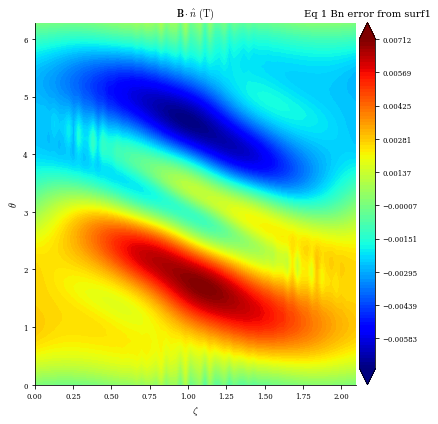

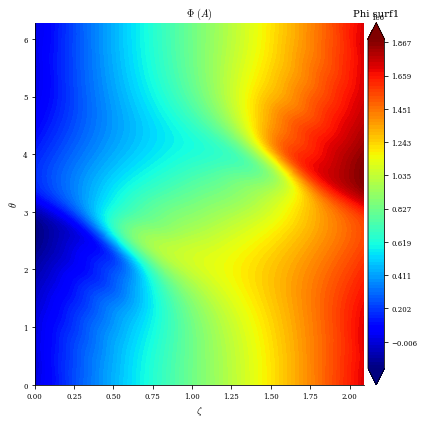

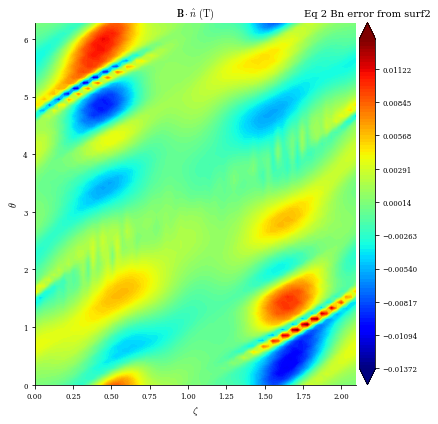

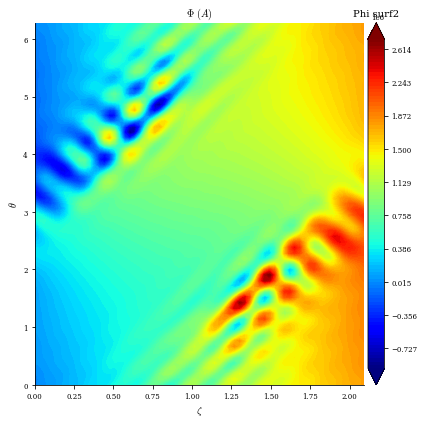

In [17]:
# look at Phi and Bn
denser_source_grid = LinearGrid(M=40,N=40,
                                #NFP=eq_QA.NFP
                               )
plot_2d(eq_QA,"B*n",field=surf1, field_grid=denser_source_grid)
plt.title("Eq 1 Bn error from surf1")

plot_2d(surf1, "Phi")
plt.title("Phi surf1")


plot_2d(eq_QH,"B*n",field=surf2, field_grid=denser_source_grid)
plt.title("Eq 2 Bn error from surf2")
plot_2d(surf2, "Phi")
plt.title("Phi surf2")

In [18]:
## setup opt problem
# use QuadraticFlux as eq's are fixed and want fields to change
# use ShareParameters to keep surface geoms constant equal
# to eachother as they vary with surface current to reduce Bn

In [19]:
# Distance target
min_QA = 0.12
max_QA = 0.25

min_QH = 0.1
max_QH = 0.25

# Distance to veseel penalization
obj_dist_QA = PlasmaVesselDistance(
    eq_QA,
    surf1,
    bounds=(min_QA,max_QA),
    #target = 0.15,
    plasma_grid=egrid,
    surface_grid=sgrid,
    eq_fixed=True,
    #softmin_alpha = 1e6,
    weight = 4.5,
    use_signed_distance=True,
    name="distance error  RQA"
)

obj_dist_QH = PlasmaVesselDistance(
    eq_QH,
    surf1,
    #target = 0.15,
    bounds=(min_QH,max_QH),
    plasma_grid=egrid,
    surface_grid=sgrid,
    eq_fixed=True,
    #softmin_alpha = 1e6,
    use_signed_distance=True,
    weight = 6.5,
    name="distance error  RQH"
)

In [20]:
mean_curv = -0.3
min_mean_curv = 0#-0.5
max_mean_curv = -0.15

obj_mean_curv = MeanCurvature(
    surf1,
    #target = mean_curv,
    bounds = (-15,-10),
    weight=1e0,
    normalize=True,
    normalize_target=True,
    deriv_mode="auto",
    grid=sgrid,
    name="Mean curvature",
)

In [21]:
obj_prin_curv = PrincipalCurvature(surf1,
        #target=None,
        bounds=(-np.inf,-10),
        weight=8e-1,
        #normalize=True,
        #normalize_target=True,
        #loss_function=None,
        #deriv_mode="auto",
        grid=sgrid,
        name="principal-curvature",
        #jac_chunk_size=None,
    )

In [22]:
obj = ObjectiveFunction((#flux_QA,
                         #flux_QH,
                         obj_dist_QA,
                         obj_dist_QH,
                         #obj_mean_curv,
                         obj_prin_curv,
                         #surf_curr_reg_QA,
                         #surf_curr_reg_QH,
                         #obj_sigma_QA,
                         #obj_sigma_QH,
                        )
                       )
constraints = (
    #FixParameters(surf1,{"G":True,}),# fix the secular poloidal current
    #FixParameters(surf2,{"G":True,}),# fix the secular poloidal current
    # make the 2 surfaces have the same geometry, dont need bc geom is fixed here
    ShareParameters([surf1,surf2],params={"R_lmn":True, "Z_lmn":True}), 
)

In [23]:
# Choose the optimizer
opt = Optimizer("lsq-exact")

In [24]:
# Run optimization
(surf1, surf2),_ = opt.optimize([surf1, surf2], 
                                 objective=obj, 
                                 constraints=constraints,
                                 verbose=3,
                                 maxiter=80,
                                ftol=0,
                                gtol=0,
                                xtol=0,
                                 options={"initial_trust_radius":np.inf})

Building objective: distance error  RQA

Precomputing transforms

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

Timer: Precomputing transforms = 121 ms

Building objective: distance error  RQH

Precomputing transforms

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

Timer: Precomputing transforms = 36.9 ms

Building objective: principal-curvature

Precomputing transforms

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

Timer: Precomputing transforms = 40.0 ms

Timer: Objective build = 260 ms

Building objective: shared parameters

Timer: Objective build = 4.99 ms

Timer: Linear constraint projection build = 2.12 sec

Number of parameters: 1879

Number of objectives: 5043

Timer: Initializing the optimization = 2.47 sec


Starting optimization

Using method: lsq-exact

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   

       0              1          9.435e+03                                    1.327e+04   

       1              3          8.962e+03      4.727e+02      3.707e-02      6.116e+03   

       2              5          8.926e+03      3.695e+01      6.886e-03      1.778e+04   

       3              6          8.845e+03      8.015e+01      1.169e-03      8.988e+03   

       4              7          8.837e+03      8.015e+00      2.856e-03      1.174e+04   

       5              8          8.806e+03      3.139e+01      6.040e-04      9.054e+03   

       6              9          8.790e+03      1.618e+01      6.348e-04      6.682e+03   

       7             10          8.781e+03      8.737e+00      7.347e-04      6.273e+03   

       8             11          8.776e+03      5.115e+00      6.940e-04      6.718e+03   

       9             12          8.768e+03      8.043e+00      6.447e-04      6.370e+03   

      10             13          8.762e+03      6.302e+00      6.662e-04      7.859e+03   

      11             14          8.758e+03      3.962e+00      6.218e-04      8.505e+03   

      12             15          8.753e+03      4.457e+00      1.513e-04      4.948e+03   

      13             16          8.747e+03      5.742e+00      3.586e-04      4.312e+03   

      14             17          8.744e+03      3.743e+00      3.670e-04      5.133e+03   

      15             18          8.742e+03      2.126e+00      3.464e-04      8.060e+03   

      16             19          8.739e+03      2.832e+00      3.129e-04      8.348e+03   

      17             20          8.737e+03      2.119e+00      7.831e-05      4.994e+03   

      18             21          8.734e+03      2.304e+00      1.673e-04      5.306e+03   

      19             22          8.733e+03      8.771e-01      1.735e-04      4.680e+03   

      20             23          8.732e+03      9.361e-01      4.315e-05      5.267e+03   

      21             24          8.731e+03      1.441e+00      9.041e-05      3.169e+03   

      22             25          8.730e+03      1.233e+00      1.990e-04      5.814e+03   

      23             26          8.729e+03      1.073e+00      1.592e-04      5.049e+03   

      24             27          8.728e+03      1.034e+00      4.046e-05      3.983e+03   

      25             28          8.727e+03      8.715e-01      8.721e-05      5.816e+03   

      26             29          8.726e+03      8.287e-01      8.440e-05      4.450e+03   

      27             30          8.725e+03      6.395e-01      8.744e-05      4.357e+03   

      28             31          8.724e+03      9.266e-01      8.998e-05      4.371e+03   

      29             32          8.724e+03      5.234e-01      8.739e-05      6.285e+03   

      30             33          8.723e+03      4.365e-01      2.229e-05      5.577e+03   

      31             34          8.723e+03      4.676e-01      4.407e-05      6.026e+03   

      32             35          8.723e+03      4.628e-01      4.094e-05      3.510e+03   

      33             36          8.722e+03      4.958e-01      4.472e-05      6.858e+03   

      34             37          8.722e+03      3.355e-01      4.412e-05      3.939e+03   

      35             38          8.721e+03      5.055e-01      4.542e-05      4.057e+03   

      36             39          8.721e+03      4.485e-01      4.843e-05      3.765e+03   

      37             40          8.720e+03      2.817e-01      4.462e-05      4.717e+03   

      38             41          8.720e+03      3.996e-01      4.236e-05      5.881e+03   

      39             42          8.720e+03      4.314e-01      4.206e-05      4.067e+03   

      40             43          8.719e+03      3.267e-01      4.292e-05      7.074e+03   

      41             44          8.719e+03      3.524e-01      4.085e-05      5.296e+03   

      42             45          8.719e+03      3.742e-01      4.226e-05      6.391e+03   

      43             46          8.718e+03      3.709e-01      4.128e-05      3.835e+03   

      44             47          8.718e+03      3.841e-01      4.373e-05      5.709e+03   

      45             48          8.717e+03      3.646e-01      4.289e-05      4.732e+03   

      46             49          8.717e+03      2.806e-01      4.216e-05      6.344e+03   

      47             50          8.717e+03      4.822e-01      4.106e-05      5.385e+03   

      48             51          8.716e+03      2.574e-01      4.243e-05      6.775e+03   

      49             52          8.716e+03      2.739e-01      3.936e-05      3.845e+03   

      50             53          8.716e+03      2.148e-01      1.127e-05      2.956e+03   

      51             54          8.716e+03      3.151e-01      2.460e-05      5.055e+03   

      52             55          8.716e+03      5.268e-02      4.448e-05      7.591e+03   

      53             56          8.715e+03      2.842e-01      9.099e-06      4.081e+03   

      54             57          8.715e+03      3.110e-01      2.101e-05      4.584e+03   

      55             58          8.715e+03      1.875e-01      2.183e-05      4.991e+03   

      56             59          8.715e+03      1.654e-01      2.066e-05      8.864e+03   

      57             60          8.714e+03      2.346e-01      2.203e-05      5.218e+03   

      58             61          8.714e+03      1.802e-01      2.258e-05      4.353e+03   

      59             62          8.714e+03      1.635e-01      2.155e-05      5.177e+03   

      60             63          8.714e+03      1.409e-01      2.085e-05      6.520e+03   

      61             64          8.714e+03      1.362e-01      1.956e-05      6.427e+03   

      62             65          8.714e+03      1.283e-01      4.657e-06      4.177e+03   

      63             66          8.714e+03      1.451e-01      1.173e-05      4.322e+03   

      64             67          8.713e+03      6.821e-02      1.137e-05      5.665e+03   

      65             68          8.713e+03      1.255e-01      1.017e-05      2.958e+03   

      66             69          8.713e+03      7.451e-02      1.093e-05      3.543e+03   

      67             70          8.713e+03      1.051e-01      1.057e-05      4.812e+03   

      68             71          8.713e+03      8.734e-02      1.090e-05      6.089e+03   

      69             72          8.713e+03      1.204e-01      1.079e-05      3.170e+03   

      70             73          8.713e+03      1.196e-01      1.201e-05      5.751e+03   

      71             74          8.713e+03      6.834e-02      1.093e-05      6.943e+03   

      72             75          8.713e+03      9.451e-02      1.053e-05      5.224e+03   

      73             76          8.713e+03      7.754e-02      1.034e-05      5.598e+03   

      74             77          8.713e+03      8.281e-02      1.012e-05      5.501e+03   

      75             78          8.712e+03      8.364e-02      1.020e-05      7.788e+03   

      76             79          8.712e+03      8.111e-02      1.020e-05      5.554e+03   

      77             80          8.712e+03      8.327e-02      1.005e-05      4.868e+03   

      78             81          8.712e+03      9.057e-02      1.029e-05      5.745e+03   

      79             82          8.712e+03      7.838e-02      1.009e-05      5.814e+03   

      80             83          8.712e+03      8.406e-02      1.002e-05      5.043e+03   

         Current function value: 8.712e+03

         Total delta_x: 3.549e-02

         Iterations: 80

         Function evaluations: 83

         Jacobian evaluations: 81

Timer: Solution time = 46.3 sec

Timer: Avg time per step = 572 ms

                                                                 Start  -->   End

Total (sum of squares):                                      9.435e+03  -->   8.712e+03, 

Maximum Plasma-vessel distance:                              3.257e-01  -->   3.141e-01 (m)

Minimum Plasma-vessel distance:                              8.101e-02  -->   6.879e-02 (m)

Average Plasma-vessel distance:                              2.011e-01  -->   1.992e-01 (m)

Maximum Plasma-vessel distance:                              3.169e+00  -->   3.056e+00 (normalized)

Minimum Plasma-vessel distance:                              7.883e-01  -->   6.694e-01 (normalized)

Average Plasma-vessel distance:                              1.957e+00  -->   1.938e+00 (normalized)

Maximum Plasma-vessel distance:                              3.097e-01  -->   2.743e-01 (m)

Minimum Plasma-vessel distance:                              6.063e-02  -->   5.113e-02 (m)

Average Plasma-vessel distance:                              1.994e-01  -->   1.975e-01 (m)

Maximum Plasma-vessel distance:                              3.235e+00  -->   2.865e+00 (normalized)

Minimum Plasma-vessel distance:                              6.333e-01  -->   5.341e-01 (normalized)

Average Plasma-vessel distance:                              2.083e+00  -->   2.062e+00 (normalized)

Maximum Principal curvature:                                 3.690e+00  -->   5.511e+00 (m^-1)

Minimum Principal curvature:                                 3.092e+00  -->   1.821e+00 (m^-1)

Average Principal curvature:                                 3.377e+00  -->   3.430e+00 (m^-1)

Maximum Principal curvature:                                 1.107e+00  -->   1.653e+00 (normalized)

Minimum Principal curvature:                                 9.275e-01  -->   5.464e-01 (normalized)

Average Principal curvature:                                 1.013e+00  -->   1.029e+00 (normalized)

Shared parameters error:                                     0.000e+00  -->   1.159e-13 (~)

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

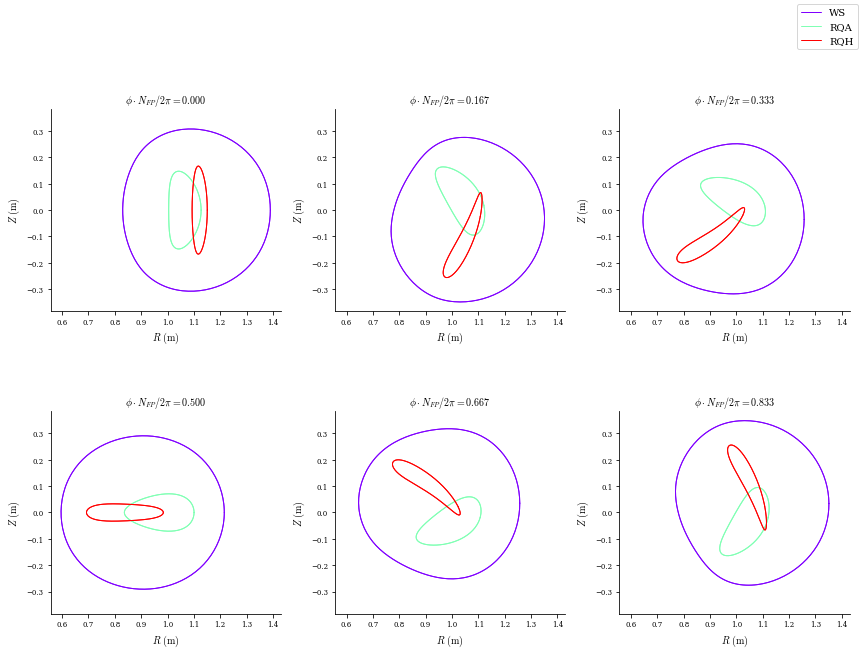

In [25]:
plot_comparison([surf1,eq_QA,eq_QH],
                labels=["WS","RQA","RQH"],
                theta=0,rho=np.array(1.0)
               )

In [26]:
surf1.save("surf_opt.h5")

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

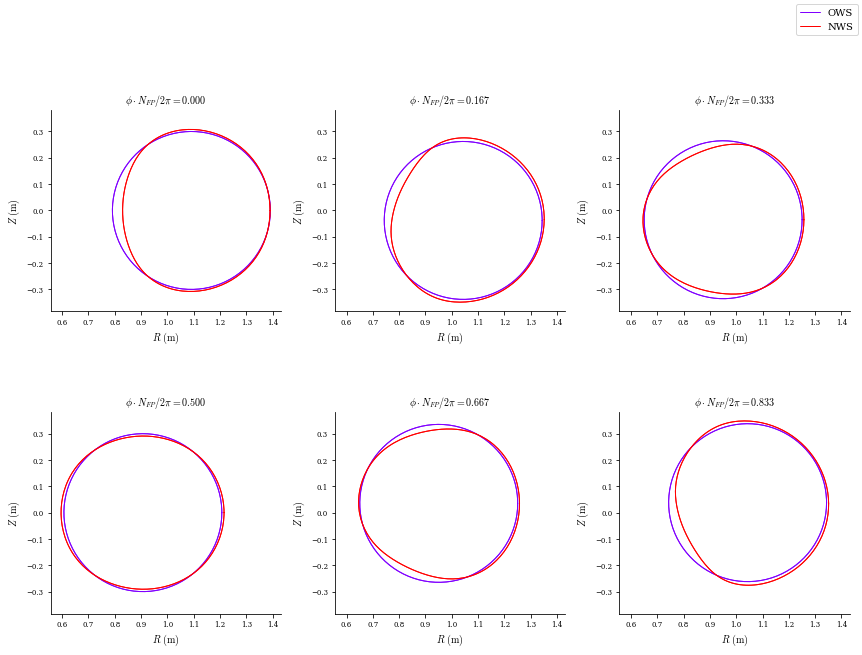

In [27]:
plot_comparison([surf,surf1],
                labels=["OWS","NWS"],
                theta=0,rho=np.array(1.0)
               )